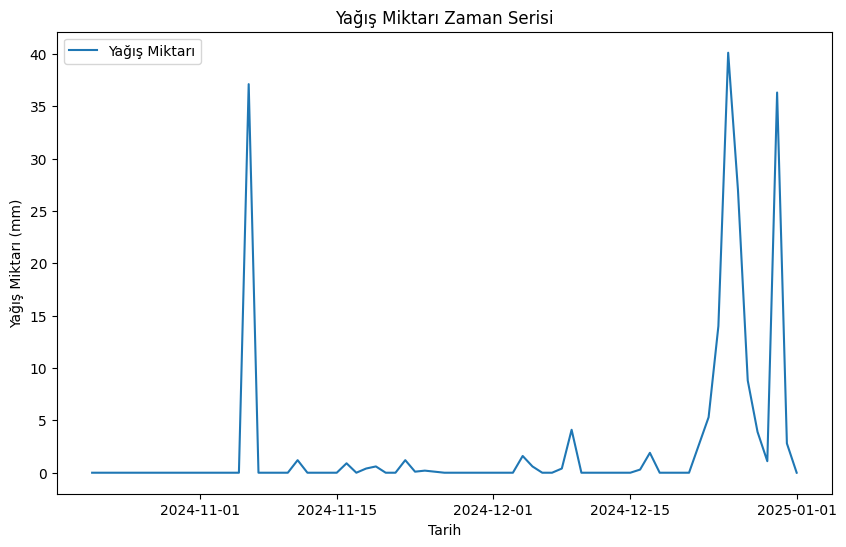

c:\Users\moztr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                       yagis_miktari   No. Observations:                   73
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood                -231.545
Date:                             Wed, 01 Jan 2025   AIC                            483.089
Time:                                     17:47:27   BIC                            504.833
Sample:                                 10-21-2024   HQIC                           491.668
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month           1.4103    274.115      0.005      0.996    -535.846     538.667
day             0.0355  

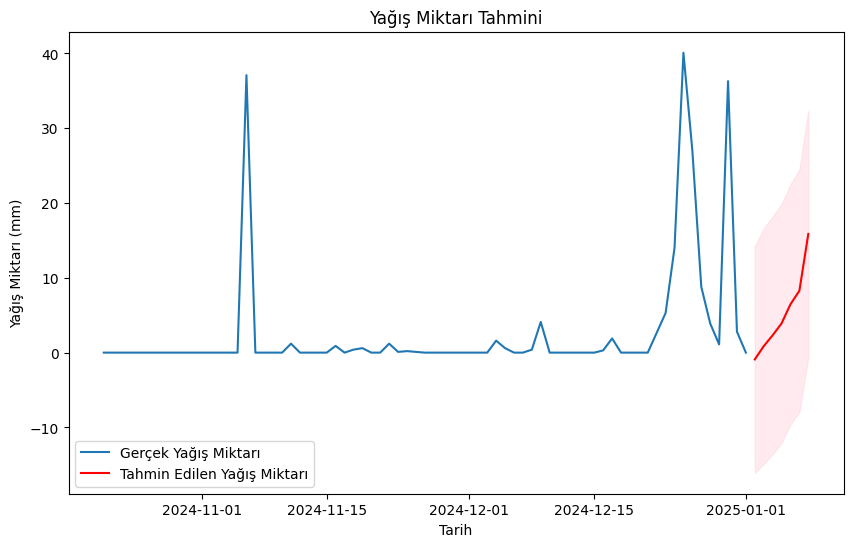

Yüklenen model ile bir hafta için tahmin edilen yağış miktarları:
2025-01-02: -0.91 mm
2025-01-03: 0.86 mm
2025-01-04: 2.32 mm
2025-01-05: 3.90 mm
2025-01-06: 6.46 mm
2025-01-07: 8.27 mm
2025-01-08: 15.87 mm


In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pickle
from datetime import timedelta

# CSV dosyasını yükleme
df = pd.read_csv('yagis_verisi.csv')

# Sadece 'yagis_miktari' ve 'tarih' sütunlarını içeren bir DataFrame oluşturma
df = df[['tarih', 'yagis_miktari']]

# 'tarih' sütununu datetime formatına çevirme
df['tarih'] = pd.to_datetime(df['tarih'], format='%Y-%m-%d')

# Yinelenen tarihleri kaldırma
df = df.drop_duplicates(subset=['tarih'])

# 'tarih' sütununu indeks olarak ayarlama ve frekans bilgisi ekleme
df.set_index('tarih', inplace=True)
df = df.asfreq('D')  # Günlük frekans

# Eksik günleri doldurma
df['yagis_miktari'] = df['yagis_miktari'].interpolate(method='time')

# Mevsimsel bileşenler ekleme
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek

# Zaman serisi verisini görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(df['yagis_miktari'], label='Yağış Miktarı')
plt.title('Yağış Miktarı Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Yağış Miktarı (mm)')
plt.legend()
plt.show()

# SARIMA modeli ile zaman serisi tahmini
exog = df[['month', 'day', 'day_of_week']]
model = SARIMAX(df['yagis_miktari'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 7), exog=exog)
model_fit = model.fit(disp=False)

# Model özetini yazdırma
print(model_fit.summary())

# Modeli kaydetme
with open('sarima_model.pkl', 'wb') as pkl:
    pickle.dump(model_fit, pkl)

# Bir hafta için tahmin yapma
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 8)]
future_exog = pd.DataFrame({
    'month': [date.month for date in future_dates],
    'day': [date.day for date in future_dates],
    'day_of_week': [date.dayofweek for date in future_dates]
})
forecast = model_fit.get_forecast(steps=7, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

print("Bir hafta için tahmin edilen yağış miktarları:")
for i, value in enumerate(forecast_mean):
    print(f"{future_dates[i].strftime('%Y-%m-%d')}: {value:.2f} mm")

# Tahmin sonuçlarını görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(df['yagis_miktari'], label='Gerçek Yağış Miktarı')
plt.plot(future_dates, forecast_mean, label='Tahmin Edilen Yağış Miktarı', color='red')
plt.fill_between(future_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Yağış Miktarı Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Yağış Miktarı (mm)')
plt.legend()
plt.show()

# Kaydedilen modeli yükleyip tahmin yapan fonksiyon
def load_model_and_forecast(model_path, steps=1, exog=None):
    with open(model_path, 'rb') as pkl:
        loaded_model = pickle.load(pkl)
    forecast = loaded_model.get_forecast(steps=steps, exog=exog)
    return forecast

# Kaydedilen modeli yükleyip bir hafta için tahmin yapma
loaded_forecast = load_model_and_forecast('sarima_model.pkl', steps=7, exog=future_exog)
loaded_forecast_mean = loaded_forecast.predicted_mean
loaded_forecast_conf_int = loaded_forecast.conf_int()

print("Yüklenen model ile bir hafta için tahmin edilen yağış miktarları:")
for i, value in enumerate(loaded_forecast_mean):
    print(f"{future_dates[i].strftime('%Y-%m-%d')}: {value:.2f} mm")